In [1]:
import torch
from torch import nn

import math

from torchvision import transforms
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader
import timm.optim.optim_factory as optim_factory
import os
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 2048
epochs = 10
l_rate = 8e-3
min_lr = 0.
gamma = 0.7
seed = 42
decay = 0.1

# 1 datapoint every 5 minutes
window_size = 144 # 12 hours
horizon = 24  # 2 hours

model_type = 'S4'

val_split = 360000
test_split = 380000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# https://github.com/state-spaces/s4/blob/main/models/s4/s4d.py
class S4DKernel(nn.Module):
    """Generate convolution kernel from diagonal SSM parameters."""

    def __init__(self, d_model, N=64, dt_min=0.001, dt_max=0.1, lr=None):
        super().__init__()
        # Generate dt
        H = d_model
        log_dt = torch.rand(H) * (
            math.log(dt_max) - math.log(dt_min)
        ) + math.log(dt_min)

        C = torch.randn(H, N // 2, dtype=torch.cfloat)
        self.C = nn.Parameter(torch.view_as_real(C))
        self.register("log_dt", log_dt, lr)

        log_A_real = torch.log(0.5 * torch.ones(H, N//2))
        A_imag = math.pi * torch.arange(N//2).repeat(H, 1)
        self.register("log_A_real", log_A_real, lr)
        self.register("A_imag", A_imag, lr)

    def forward(self, L):
        """
        returns: (..., c, L) where c is number of channels (default 1)
        """

        # Materialize parameters
        dt = torch.exp(self.log_dt) # (H)
        C = torch.view_as_complex(self.C) # (H N)
        A = -torch.exp(self.log_A_real) + 1j * self.A_imag # (H N)

        # Vandermonde multiplication
        dtA = A * dt.unsqueeze(-1)  # (H N)
        K = dtA.unsqueeze(-1) * torch.arange(L, device=A.device) # (H N L)
        C = C * (torch.exp(dtA)-1.) / A
        K = 2 * torch.einsum('hn, hnl -> hl', C, torch.exp(K)).real

        return K

    def register(self, name, tensor, lr=None):
        """Register a tensor with a configurable learning rate and 0 weight decay"""

        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))

            optim = {"weight_decay": 0.0}
            if lr is not None: optim["lr"] = lr
            setattr(getattr(self, name), "_optim", optim)


class S4D(nn.Module):
    def __init__(self, d_model, d_state=64, dropout=0.0, transposed=True, **kernel_args):
        super().__init__()

        self.h = d_model
        self.n = d_state
        self.d_output = self.h
        self.transposed = transposed

        self.D = nn.Parameter(torch.randn(self.h))

        # SSM Kernel
        self.kernel = S4DKernel(self.h, N=self.n, **kernel_args)

        # Pointwise
        self.activation = nn.GELU()
        # dropout_fn = nn.Dropout2d # NOTE: bugged in PyTorch 1.11
        dropout_fn = nn.Dropout
        self.dropout = dropout_fn(dropout) if dropout > 0.0 else nn.Identity()

        # position-wise output transform to mix features
        self.output_linear = nn.Sequential(
            nn.Conv1d(self.h, 2*self.h, kernel_size=1),
            nn.GLU(dim=-2),
        )

    def forward(self, u, **kwargs): # absorbs return_output and transformer src mask
        """ Input and output shape (B, H, L) """
        if not self.transposed: u = u.transpose(-1, -2)
        L = u.size(-1)

        # Compute SSM Kernel
        k = self.kernel(L=L) # (H L)

        # Convolution
        k_f = torch.fft.rfft(k, n=2*L) # (H L)
        u_f = torch.fft.rfft(u, n=2*L) # (B H L)
        y = torch.fft.irfft(u_f*k_f, n=2*L)[..., :L] # (B H L)

        # Compute D term in state space equation - essentially a skip connection
        y = y + u * self.D.unsqueeze(-1)

        y = self.dropout(self.activation(y))
        y = self.output_linear(y)
        if not self.transposed: y = y.transpose(-1, -2)
        return y, None # Return a dummy state to satisfy this repo's interface, but this can be modified

In [4]:
class S4Model(nn.Module):
    def __init__(
        self,
        d_input=4,
        d_output=2,
        d_model=128,
        n_layers=4,
        dropout=0.2,
        prenorm=False,
    ):
        super().__init__()

        self.prenorm = prenorm

        # Linear encoder (d_input = 1 for grayscale and 3 for RGB)
        self.encoder = nn.Linear(d_input, d_model)

        # Stack S4 layers as residual blocks
        self.s4_layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for _ in range(n_layers):
            self.s4_layers.append(
                S4D(d_model, dropout=dropout, transposed=True, lr=min(0.001, 0.01))
            )
            self.norms.append(nn.LayerNorm(d_model))
            self.dropouts.append(nn.Dropout(dropout))

        # Linear decoder
        self.decoder = nn.Linear(d_model, d_output)

    def forward(self, x):
        """
        Input x is shape (B, L, d_input)
        """
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)

        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
        for layer, norm, dropout in zip(self.s4_layers, self.norms, self.dropouts):
            # Each iteration of this loop will map (B, d_model, L) -> (B, d_model, L)

            z = x
            if self.prenorm:
                # Prenorm
                z = norm(z.transpose(-1, -2)).transpose(-1, -2)

            # Apply S4 block: we ignore the state input and output
            z, _ = layer(z)

            # Dropout on the output of the S4 block
            z = dropout(z)

            # Residual connection
            x = z + x

            if not self.prenorm:
                # Postnorm
                x = norm(x.transpose(-1, -2)).transpose(-1, -2)

        x = x.transpose(-1, -2)

        x = self.decoder(x)  # (B, d_model) -> (B, d_output)

        return x[:, -1]

In [5]:
class LSTM(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.lstm = nn.LSTM(input_size=4, hidden_size=dim, num_layers=1, batch_first=True)
        self.linear = nn.Linear(dim, 2)
    
    def forward(self, x):
        _, x = self.lstm(x)
        x = x[0]
        x = self.linear(x)
        return x[0]

In [6]:
# 4 years of patient data
# 3 patients
patients = np.load('/data/data.npy', allow_pickle=True)
patient4 = patients[()]['patient4'].astype(np.float64)
patient5 = patients[()]['patient5'].astype(np.float64)
patient5 = np.nan_to_num(patient5, 0)

def normalize(data, index):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    
    data[:, index] = (data[:, index] - mean[index]) / std[index]
    
    return data

def normalize_by_std(data, index):
    std = np.std(data, axis=0)
    
    data[:, index] = (data[:, index]) / std[index]
    
    return data

patient4 = normalize(patient4, 0)
patient4 = normalize_by_std(patient4, 2)
patient4 = normalize_by_std(patient4, 3)
print(patient4.shape)

patient5 = normalize(patient5, 0)
patient5 = normalize_by_std(patient5, 2)
patient5 = normalize_by_std(patient5, 3)
print(patient5.shape)

(417240, 4)
(416528, 4)


In [7]:
def sliding_window(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size][:2])
    
    return X, y

class DBS(Dataset):
    def __init__(self, X, y):
        super(DBS, self).__init__()

        self.X = np.array(X).astype(np.float32)
        self.y = np.array(y).astype(np.float32)
        
        print(self.X.shape)
        print(self.y.shape)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

patient4_train = sliding_window(patient4[:val_split], window_size) 
patient5_train = sliding_window(patient5[:val_split], window_size)
X_train, y_train = patient4_train[0] + patient5_train[0], patient4_train[1] + patient5_train[1]

patient4_val = sliding_window(patient4[val_split:test_split], window_size) 
patient5_val = sliding_window(patient5[val_split:test_split], window_size)
X_val, y_val = patient4_val[0] + patient5_val[0], patient4_val[1] + patient5_val[1]

trainset = DBS(X_train, y_train)
valset = DBS(X_val, y_val)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

(719712, 144, 4)
(719712, 2)
(39712, 144, 4)
(39712, 2)


In [8]:
# Define model
model = S4Model().to(device) if model_type == 'S4' else LSTM(128).to(device)

def params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    n_params = sum([np.prod(p.size()) for p in model_parameters])
    return n_params
print(params(model)) # model size

200578


In [9]:
criterion = nn.MSELoss()
param_groups = optim_factory.param_groups_weight_decay(model, decay)
optimizer = torch.optim.AdamW(param_groups, lr=l_rate, betas=(0.9, 0.95))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

In [10]:
for ep in range(epochs):
    model.train()
    train_loss = 0.0
    pbar = tqdm(trainloader, unit='batch', disable=False)
    for i, (X, y) in enumerate(pbar):
        X = X.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        outputs = model(X)
        
        loss = torch.sqrt(criterion(outputs, y))
        
        train_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

        loss.backward()
        optimizer.step()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    print(f'Epoch {ep}, loss: {train_loss / len(trainloader)}')
    
    model.eval()
    total = 0
    val_loss = 0
    with torch.no_grad():
        for X, y in tqdm(valloader):
            X = X.to(device)
            y = y.to(device)
            
            outputs = model(X)
            val_loss += torch.sqrt(criterion(outputs, y)).item()
    
    print(f'Epoch {ep},  Val Loss: {val_loss / len(valloader)}')
    
    scheduler.step()

  0%|          | 0/352 [00:00<?, ?batch/s]

Epoch 0, loss: 0.18345952774821359


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0,  Val Loss: 0.08587146922945976


  0%|          | 0/352 [00:00<?, ?batch/s]

Epoch 1, loss: 0.09103807330724191


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1,  Val Loss: 0.06190887950360775


  0%|          | 0/352 [00:00<?, ?batch/s]

Epoch 2, loss: 0.07487769556147131


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2,  Val Loss: 0.04890821725130081


  0%|          | 0/352 [00:00<?, ?batch/s]

Epoch 3, loss: 0.06858473779125647


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3,  Val Loss: 0.04863779488950968


  0%|          | 0/352 [00:00<?, ?batch/s]

Epoch 4, loss: 0.06414208799304272


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4,  Val Loss: 0.04493487291038036


  0%|          | 0/352 [00:00<?, ?batch/s]

Epoch 5, loss: 0.06093499335375699


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5,  Val Loss: 0.03928324468433857


  0%|          | 0/352 [00:00<?, ?batch/s]

Epoch 6, loss: 0.05825589632149786


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6,  Val Loss: 0.037526368722319604


  0%|          | 0/352 [00:00<?, ?batch/s]

Epoch 7, loss: 0.05609410780016333


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7,  Val Loss: 0.03659828873351216


  0%|          | 0/352 [00:00<?, ?batch/s]

Epoch 8, loss: 0.0543485689506104


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8,  Val Loss: 0.03282578429207206


  0%|          | 0/352 [00:00<?, ?batch/s]

Epoch 9, loss: 0.05323364321057769


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9,  Val Loss: 0.03292255774140358


In [11]:
def predict(loader, n=24, dp=1):
    X = None
    y = None
    for i, (X, y) in list(enumerate(loader))[:dp]:
        X = X.to(device)
        y = y.to(device)
    
    print(X.shape)
    
    actual = X[0][:, 0]
    pred = X[:1]
    for i in range(n):
        out = model(pred)[0]#[0]
        pred = torch.cat((pred, torch.Tensor([[[out[0], out[1], 0, 0]]]).to(device)), dim=1)
        actual_out = torch.Tensor([y[i][0]]).to(device)
        actual = torch.cat((actual, actual_out), dim=0)
    
    pred = pred[0, :, 0]
    x = np.arange(window_size + n)
    
    plt.plot(x, actual.cpu())
    plt.plot(x, pred.cpu())

torch.Size([2048, 144, 4])


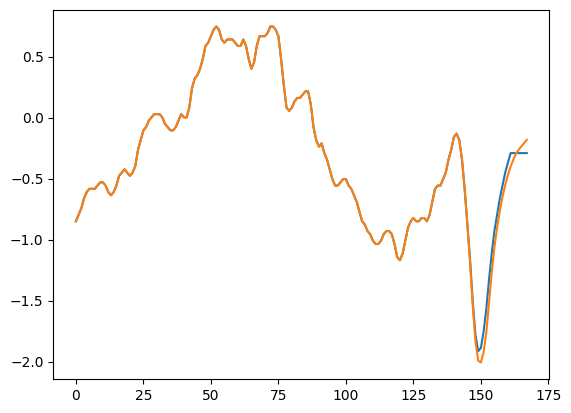

In [12]:
predict(valloader, 24, 1)

In [19]:
# Coeff calculation

def sliding_window_for_metrics(data, window_size=window_size, n=horizon):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(np.array(data[i:i+window_size]))
        y.append(np.array(data[i+window_size:i+window_size+n][:, 0]))
    
    print(y[0].shape)
    while y[-1].shape[-1] != n:
        X.pop()
        y.pop()
        
    return X, y

def calc_cor(model, loader, n=24):
    global device
    
    model.eval()
    pbar = tqdm(loader, unit='batch', disable=False)
    cor = []
    
    with torch.no_grad():
        for i, (X, y) in enumerate(pbar):
            b = X.shape[0]
            
            X = X.to(device)
            y = y.to(device)[:, :n]

            pred = X
            for i in range(n):
                out = model(pred)
                out = torch.cat((out, torch.zeros(b, 2).to(device)), dim=-1)
                out = out.reshape(b, 1, out.shape[-1])
                pred = torch.cat((pred, out), dim=1)

            pred = pred[:, -n:, 0].cpu()
            y = y.cpu()
            cor += [np.corrcoef(yt, predt)[0,1] for yt, predt in zip(y, pred)]
    
    cor = np.mean(cor)
    return cor

In [20]:
# cross patient prediction
# Since, I'm not using the validation for model selection, simply test on it for now
def test_patient(model, patients, patient, n=horizon):
    test_data = np.nan_to_num(patients[()][patient].astype(np.float64), 0)[val_split:]
    test_data = normalize(test_data, 0)
    test_data = normalize_by_std(test_data, 2)
    test_data = normalize_by_std(test_data, 3)

    X_test, y_test = sliding_window_for_metrics(test_data, window_size, n)

    testset = DBS(X_test, y_test)

    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    cor = calc_cor(model, testloader, n)
    print(f'{patient} correlation: {cor}')

test_patient(model, patients, 'patient6', 12)
test_patient(model, patients, 'patient4')
test_patient(model, patients, 'patient5')

(12,)
(56525, 144, 4)
(56525, 12)


  0%|          | 0/28 [00:00<?, ?batch/s]

patient6 correlation: 0.39524169054564146
(24,)
(57073, 144, 4)
(57073, 24)


  0%|          | 0/28 [00:00<?, ?batch/s]

patient4 correlation: 0.9661157211318167
(24,)
(56361, 144, 4)
(56361, 24)


  0%|          | 0/28 [00:00<?, ?batch/s]

patient5 correlation: 0.9495023290610148
